# Thư viện

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Hàm

### Tách dữ liệu

In [ ]:
def df_to_X_y(df, window_size = 6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np) - window_size):
    row = [r for r in df_as_np[i : i + window_size]]
    X.append(row)
    label = []
    for j in range(len(df.columns) - 4):
      label.append(df_as_np[i + window_size][j])
    y.append(label)
  return np.array(X), np.array(y)

### Giải mã dữ liệu chuẩn hóa

In [ ]:
def post_process(arr, index=0):
  arr = (arr * std[index]) + mean[index]
  return arr

### Trực quan hóa dữ liệu

Hiển thị biểu đồ nhóm đặc trưng

In [ ]:
def plot_predictions(model, X, y, list_name, show=True, start=0, end=-1):
  predictions = model.predict(X)
  preds, actuals = [], []

  for i in range(predictions.shape[1]):
    preds.append(post_process(predictions[:, i], i))
    actuals.append(post_process(y[:, i], i))
    
  data = {}
  a = []
  list_name = list(list_name.columns)
  list_name.remove('Ngày sin')
  list_name.remove('Ngày cos')
  list_name.remove('Năm sin')
  list_name.remove('Năm cos')


  for i in range(predictions.shape[1]):
    Name_pred = list_name[i] + ' dự đoán'
    Name_actual = list_name[i] + ' thực tế' 
    data[Name_pred] = preds[i]
    data[Name_actual] = actuals[i]

  df = pd.DataFrame(data=data)

  if show:
    plt.figure(figsize=(24, 10))
  
  for i in df[start:end]:
    a.append(i)
    if show:
      plt.plot(df[i])
  
  if show:
    plt.legend(a)
  
  return df

Hiển thị biểu đồ từng đặc trưng

In [ ]:
def plot_prediction(name, start=0, end=-1):
  post_processed_df = plot_predictions(model, X_test, y_test, df_temp, False)
  name_pred = name + ' dự đoán'
  name_actual = name + ' thực tế'
  plt.figure(figsize=(24, 10))
  plt.plot(post_processed_df[name_pred][start:end])
  plt.plot(post_processed_df[name_actual][start:end])
  plt.legend([name_pred, name_actual])

# Dữ liệu

In [ ]:
drive_path = 'drive/MyDrive/Internship/RNN/'
xlsx_path = os.path.join(drive_path, 'Data.xlsx')

### Đọc flie
df = pd.read_excel(xlsx_path)

### Đặt ngày giờ làm index
df.index = pd.to_datetime(df['Ngày giờ'], format='%Y-%m-%d %H:%M:%S')

### Xóa các dữ liệu không cần thiết
df = df.drop(['Ngày giờ', 'Kết luận', 'Trạng thái mưa'], axis=1)

### Chuẩn hóa
df['Xác suất mưa'] = df['Xác suất mưa'] / 100
for index, value in enumerate(df['Áp suất']):
  if value > 0:
    pass
  else:
    df['Áp suất'][index] = df['Áp suất'].mean()

for index, value in enumerate(df['Tầm nhìn']):
  if value > 0.0:
    pass
  else:
    df['Tầm nhìn'][index] = df['Tầm nhìn'].mean()

for index, value in enumerate(df['Chỉ số UV']):
  if value > 0:
    pass
  else:
    df['Chỉ số UV'][index] = df['Chỉ số UV'].mean()

### Thêm hệ số ngày và năm
day = 60 * 60 * 24
year = 365.2425 * day
df['Giây'] = df.index.map(pd.Timestamp.timestamp)
df['Ngày sin'] = np.sin(df['Giây'] * (2 * np.pi / day))
df['Ngày cos'] = np.cos(df['Giây'] * (2 * np.pi / day))
df['Năm sin'] = np.sin(df['Giây'] * (2 * np.pi / year))
df['Năm cos'] = np.cos(df['Giây'] * (2 * np.pi / year))
df = df.drop('Giây', axis=1)

# Thông số

In [ ]:
EPOCHS = 200
LR = 2e-5
### Số input
WINDOW_SIZE = 24
TRAIN_RATIO = 0.7
VALRATIO = 0.2
drive_path = 'drive/MyDrive/Internship/RNN/Model/'
### Checkpoint early stoping
cp_es = EarlyStopping(patience=2)

# Nhiệt độ + Nhiệt độ cảm giác

### Khai thác dữ liệu cần thiết

In [ ]:
df_temp = df[[
    'Nhiệt độ',
    'Nhiệt độ cảm giác',
    'Ngày sin', 'Ngày cos', 'Năm sin', 'Năm cos']]

### Tách dữ liệu

In [ ]:
X, y = df_to_X_y(df_temp, WINDOW_SIZE)

length = len(X)
begin = int(length * TRAIN_RATIO)
end = int(length * (TRAIN_RATIO + VALRATIO))

X_train, y_train = X[ : begin], y[ : begin]
X_val, y_val = X[begin : end], y[begin : end]
X_test, y_test = X[end : ], y[end : ]

X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_val = np.asarray(X_val).astype('float32')
y_val = np.asarray(y_val).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

### Chuẩn hóa dữ liệu

In [ ]:
mean, std = [], []

for i in range(len(df_temp.columns) - 4):
  mean.append(np.mean(X_train[:, :, i]))
  std.append(np.std(X_train[:, :, i]))

for i in range(len(df_temp.columns) - 4):
  X_train[:, :, i] = (X_train[:, :, i] - mean[i]) / std[i]
  X_val[:, :, i] = (X_val[:, :, i] - mean[i]) / std[i]
  X_test[:, :, i] = (X_test[:, :, i] - mean[i]) / std[i]
   
  y_train[:, i] = (y_train[:, i] - mean[i]) / std[i]
  y_val[:, i] = (y_val[:, i] - mean[i]) / std[i]
  y_test[:, i] = (y_test[:, i] - mean[i]) / std[i]

### Model

##### Train

In [ ]:
model_path = drive_path + 'Model_NhietDo/'
cp_bs = ModelCheckpoint(model_path, save_best_only=True)

model = Sequential()
model.add(InputLayer((WINDOW_SIZE, len(df_temp.columns))))
model.add(Conv1D(64, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(16, 'relu'))
model.add(Dense(len(df_temp.columns) - 4, 'linear'))

model.summary()

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=LR), metrics=[RootMeanSquaredError()])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, callbacks=[cp_bs, cp_es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 64)            832       
                                                                 
 flatten (Flatten)           (None, 1472)              0         
                                                                 
 dense (Dense)               (None, 16)                23568     
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 24,434
Trainable params: 24,434
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
579/579 [==============================] - 3s 5ms/step - loss: 0.2793 - root_mean_squared_error: 0.5285 - val_loss: 0.1458 - val_root_mean_squared_error: 0.3819
Epoch 2/50
5

##### Test

Nhiệt độ dự đoán  Nhiệt độ thực tế  Nhiệt độ cảm giác dự đoán  \
0            27.850191              28.0                  31.562222   
1            28.697592              28.0                  33.121433   
2            28.317720              27.9                  32.528820   
3            27.390701              28.0                  31.558861   
4            27.700502              27.0                  31.851099   
...                ...               ...                        ...   
2309         27.409859              27.0                  31.244349   
2310         26.509890              26.0                  29.718508   
2311         25.892439              26.0                  27.077929   
2312         26.389679              27.0                  27.757675   
2313         26.780443              27.0                  29.658936   

      Nhiệt độ cảm giác thực tế  
0                     32.700001  
1                     32.700001  
2                     32.599998  
3                     33.500000  
4                     31.200001  
...                         ...  
2309                  30.000000  
2310                  26.000000  
2311                  26.000000  
2312                  30.500000  
2313                  30.500000  

[2314 rows x 4 columns]

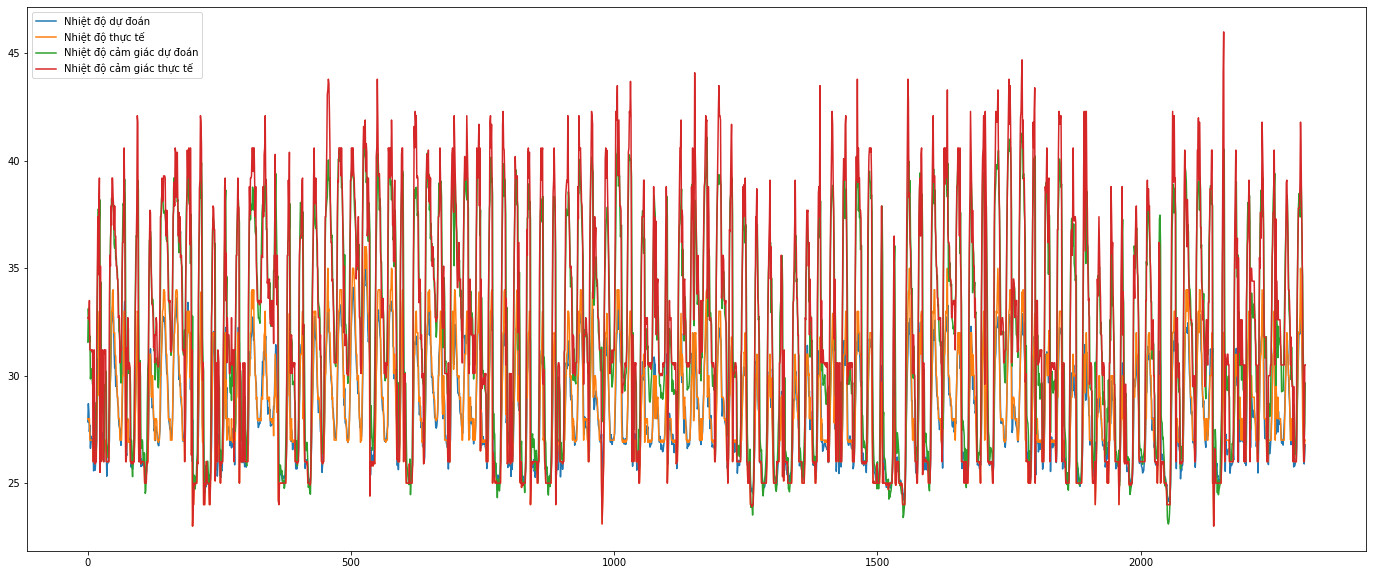

In [ ]:
model = load_model(model_path)
plot_predictions(model, X_test, y_test, df_temp)

##### Visualize

Nhiệt độ

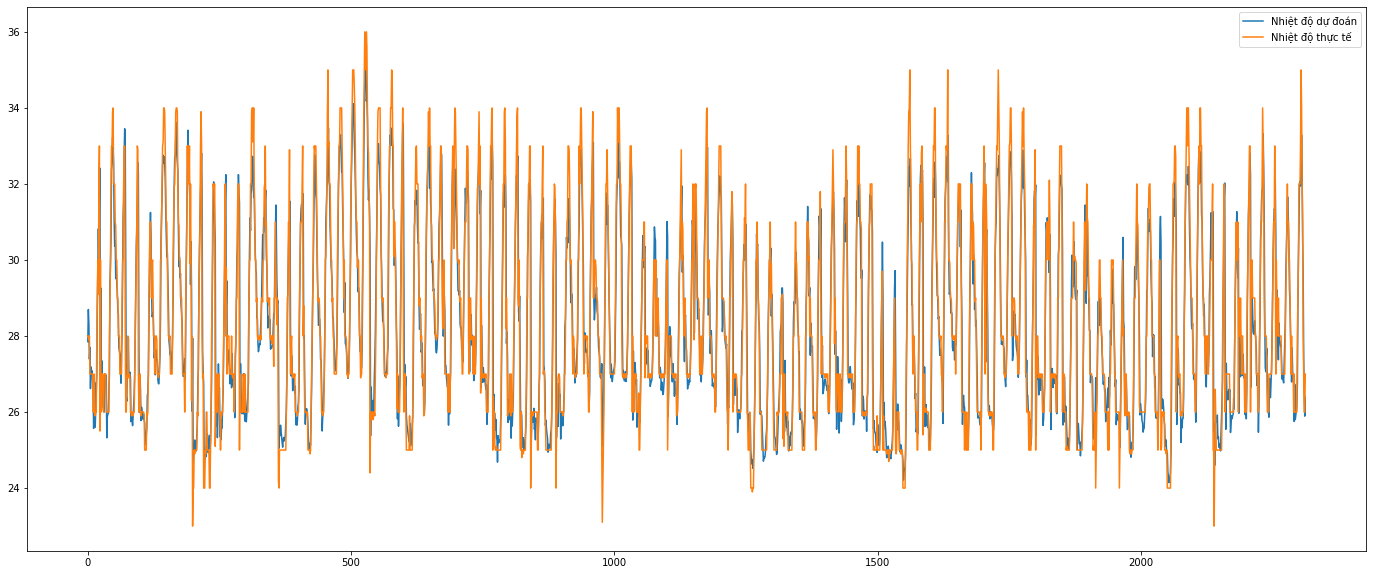

In [ ]:
plot_prediction('Nhiệt độ')

Nhiệt độ cảm giác

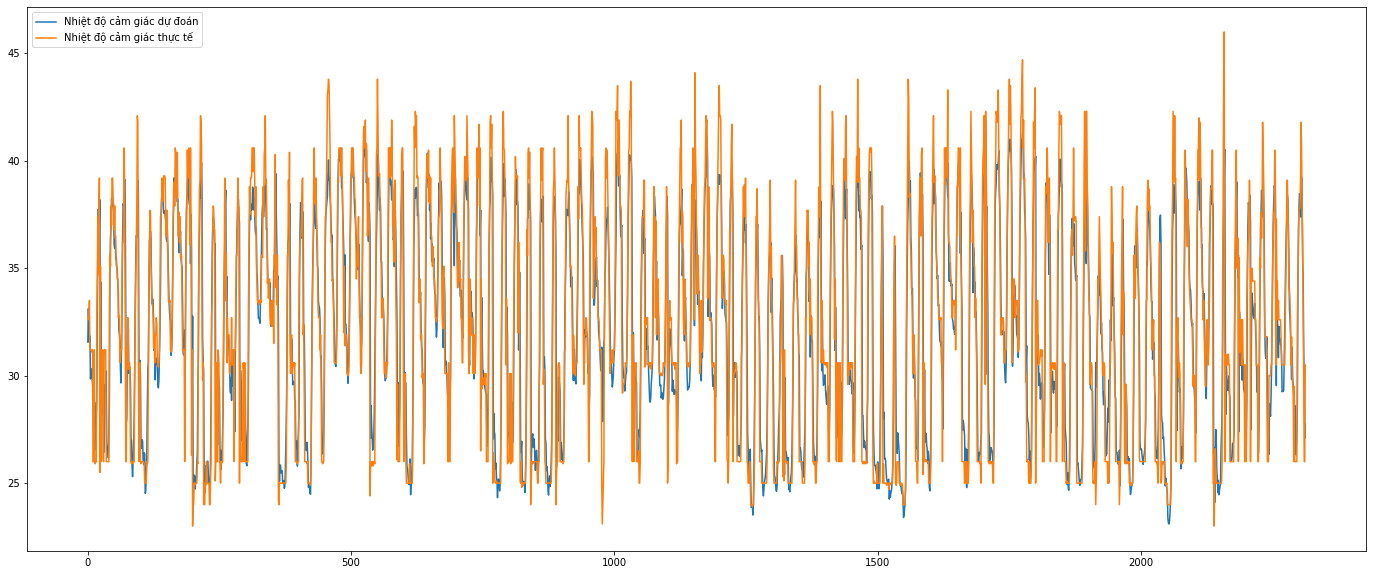

In [ ]:
plot_prediction('Nhiệt độ cảm giác')

# Độ ẩm + Mưa + Xác xuất mưa + Áp suất

### Khai thác dữ liệu cần thiết

In [ ]:
df_temp = df[[
    'Độ ẩm',
    'Mưa',
    'Xác suất mưa',
    'Áp suất',
    'Ngày sin', 'Ngày cos', 'Năm sin', 'Năm cos']]

### Tách dữ liệu

In [ ]:
X, y = df_to_X_y(df_temp, WINDOW_SIZE)

length = len(X)
begin = int(length * TRAIN_RATIO)
end = int(length * (TRAIN_RATIO + VALRATIO))

X_train, y_train = X[ : begin], y[ : begin]
X_val, y_val = X[begin : end], y[begin : end]
X_test, y_test = X[end : ], y[end : ]

X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_val = np.asarray(X_val).astype('float32')
y_val = np.asarray(y_val).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

### Chuẩn hóa dữ liệu

In [ ]:
mean, std = [], []

for i in range(len(df_temp.columns) - 4):
  mean.append(np.mean(X_train[:, :, i]))
  std.append(np.std(X_train[:, :, i]))

for i in range(len(df_temp.columns) - 4):
  X_train[:, :, i] = (X_train[:, :, i] - mean[i]) / std[i]
  X_val[:, :, i] = (X_val[:, :, i] - mean[i]) / std[i]
  X_test[:, :, i] = (X_test[:, :, i] - mean[i]) / std[i]
   
  y_train[:, i] = (y_train[:, i] - mean[i]) / std[i]
  y_val[:, i] = (y_val[:, i] - mean[i]) / std[i]
  y_test[:, i] = (y_test[:, i] - mean[i]) / std[i]

### Model

##### Train

In [ ]:
model_path = drive_path + 'Model_Mua/'
cp_bs = ModelCheckpoint(model_path, save_best_only=True)

model = Sequential()
model.add(InputLayer((WINDOW_SIZE, len(df_temp.columns))))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32,))
model.add(Dense(32, 'relu'))
model.add(Dense(16, 'relu'))
model.add(Dense(len(df_temp.columns) - 4, 'linear'))

model.summary()

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=LR), metrics=[RootMeanSquaredError()])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, callbacks=[cp_bs, cp_es])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            18688     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 4)                 68        
                                                                 
Total params: 32,756
Trainable params: 32,756
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
577/579 [============================>.

579/579 [==============================] - 32s 43ms/step - loss: 0.9179 - root_mean_squared_error: 0.9581 - val_loss: 0.7243 - val_root_mean_squared_error: 0.8510
Epoch 2/50
578/579 [============================>.] - ETA: 0s - loss: 0.7723 - root_mean_squared_error: 0.8788

579/579 [==============================] - 24s 41ms/step - loss: 0.7820 - root_mean_squared_error: 0.8843 - val_loss: 0.6301 - val_root_mean_squared_error: 0.7938
Epoch 3/50
578/579 [============================>.] - ETA: 0s - loss: 0.7092 - root_mean_squared_error: 0.8421

579/579 [==============================] - 25s 43ms/step - loss: 0.7090 - root_mean_squared_error: 0.8420 - val_loss: 0.5696 - val_root_mean_squared_error: 0.7547
Epoch 4/50
578/579 [============================>.] - ETA: 0s - loss: 0.6635 - root_mean_squared_error: 0.8146

579/579 [==============================] - 25s 42ms/step - loss: 0.6633 - root_mean_squared_error: 0.8145 - val_loss: 0.5210 - val_root_mean_squared_error: 0.7218
Epoch 5/50
577/579 [============================>.] - ETA: 0s - loss: 0.6335 - root_mean_squared_error: 0.7959

579/579 [==============================] - 24s 41ms/step - loss: 0.6338 - root_mean_squared_error: 0.7961 - val_loss: 0.4932 - val_root_mean_squared_error: 0.7023
Epoch 6/50
577/579 [============================>.] - ETA: 0s - loss: 0.6160 - root_mean_squared_error: 0.7848

579/579 [==============================] - 24s 41ms/step - loss: 0.6158 - root_mean_squared_error: 0.7848 - val_loss: 0.4760 - val_root_mean_squared_error: 0.6899
Epoch 7/50
577/579 [============================>.] - ETA: 0s - loss: 0.5897 - root_mean_squared_error: 0.7679

579/579 [==============================] - 24s 42ms/step - loss: 0.6039 - root_mean_squared_error: 0.7771 - val_loss: 0.4653 - val_root_mean_squared_error: 0.6821
Epoch 8/50
579/579 [==============================] - ETA: 0s - loss: 0.5946 - root_mean_squared_error: 0.7711

579/579 [==============================] - 23s 40ms/step - loss: 0.5946 - root_mean_squared_error: 0.7711 - val_loss: 0.4562 - val_root_mean_squared_error: 0.6755
Epoch 9/50
579/579 [==============================] - ETA: 0s - loss: 0.5866 - root_mean_squared_error: 0.7659

579/579 [==============================] - 25s 43ms/step - loss: 0.5866 - root_mean_squared_error: 0.7659 - val_loss: 0.4490 - val_root_mean_squared_error: 0.6701
Epoch 10/50
577/579 [============================>.] - ETA: 0s - loss: 0.5803 - root_mean_squared_error: 0.7618

579/579 [==============================] - 24s 42ms/step - loss: 0.5800 - root_mean_squared_error: 0.7616 - val_loss: 0.4415 - val_root_mean_squared_error: 0.6645
Epoch 11/50
579/579 [==============================] - ETA: 0s - loss: 0.5745 - root_mean_squared_error: 0.7579

579/579 [==============================] - 23s 40ms/step - loss: 0.5745 - root_mean_squared_error: 0.7579 - val_loss: 0.4361 - val_root_mean_squared_error: 0.6604
Epoch 12/50
577/579 [============================>.] - ETA: 0s - loss: 0.5704 - root_mean_squared_error: 0.7553

579/579 [==============================] - 24s 42ms/step - loss: 0.5697 - root_mean_squared_error: 0.7548 - val_loss: 0.4311 - val_root_mean_squared_error: 0.6566
Epoch 13/50
579/579 [==============================] - ETA: 0s - loss: 0.5655 - root_mean_squared_error: 0.7520

579/579 [==============================] - 23s 39ms/step - loss: 0.5655 - root_mean_squared_error: 0.7520 - val_loss: 0.4254 - val_root_mean_squared_error: 0.6522
Epoch 14/50
578/579 [============================>.] - ETA: 0s - loss: 0.5623 - root_mean_squared_error: 0.7499

579/579 [==============================] - 24s 42ms/step - loss: 0.5621 - root_mean_squared_error: 0.7497 - val_loss: 0.4219 - val_root_mean_squared_error: 0.6495
Epoch 15/50
579/579 [==============================] - ETA: 0s - loss: 0.5590 - root_mean_squared_error: 0.7476

579/579 [==============================] - 25s 43ms/step - loss: 0.5590 - root_mean_squared_error: 0.7476 - val_loss: 0.4197 - val_root_mean_squared_error: 0.6479
Epoch 16/50
578/579 [============================>.] - ETA: 0s - loss: 0.5566 - root_mean_squared_error: 0.7460

579/579 [==============================] - 24s 41ms/step - loss: 0.5563 - root_mean_squared_error: 0.7458 - val_loss: 0.4143 - val_root_mean_squared_error: 0.6436
Epoch 17/50
578/579 [============================>.] - ETA: 0s - loss: 0.5542 - root_mean_squared_error: 0.7444

579/579 [==============================] - 24s 41ms/step - loss: 0.5540 - root_mean_squared_error: 0.7443 - val_loss: 0.4128 - val_root_mean_squared_error: 0.6425
Epoch 18/50
578/579 [============================>.] - ETA: 0s - loss: 0.5518 - root_mean_squared_error: 0.7428

579/579 [==============================] - 23s 40ms/step - loss: 0.5517 - root_mean_squared_error: 0.7427 - val_loss: 0.4098 - val_root_mean_squared_error: 0.6402
Epoch 19/50
578/579 [============================>.] - ETA: 0s - loss: 0.5500 - root_mean_squared_error: 0.7416

579/579 [==============================] - 23s 39ms/step - loss: 0.5499 - root_mean_squared_error: 0.7415 - val_loss: 0.4097 - val_root_mean_squared_error: 0.6401
Epoch 20/50
577/579 [============================>.] - ETA: 0s - loss: 0.5487 - root_mean_squared_error: 0.7408

579/579 [==============================] - 24s 41ms/step - loss: 0.5481 - root_mean_squared_error: 0.7403 - val_loss: 0.4066 - val_root_mean_squared_error: 0.6377
Epoch 21/50
578/579 [============================>.] - ETA: 0s - loss: 0.5466 - root_mean_squared_error: 0.7394

579/579 [==============================] - 24s 42ms/step - loss: 0.5463 - root_mean_squared_error: 0.7391 - val_loss: 0.4056 - val_root_mean_squared_error: 0.6369
Epoch 22/50
579/579 [==============================] - ETA: 0s - loss: 0.5449 - root_mean_squared_error: 0.7381

579/579 [==============================] - 24s 42ms/step - loss: 0.5449 - root_mean_squared_error: 0.7381 - val_loss: 0.4055 - val_root_mean_squared_error: 0.6368
Epoch 23/50
577/579 [============================>.] - ETA: 0s - loss: 0.5437 - root_mean_squared_error: 0.7373

579/579 [==============================] - 23s 41ms/step - loss: 0.5434 - root_mean_squared_error: 0.7372 - val_loss: 0.4014 - val_root_mean_squared_error: 0.6335
Epoch 24/50
577/579 [============================>.] - ETA: 0s - loss: 0.5387 - root_mean_squared_error: 0.7340

579/579 [==============================] - 23s 40ms/step - loss: 0.5422 - root_mean_squared_error: 0.7363 - val_loss: 0.3999 - val_root_mean_squared_error: 0.6324
Epoch 25/50
578/579 [============================>.] - ETA: 0s - loss: 0.5410 - root_mean_squared_error: 0.7356

579/579 [==============================] - 24s 42ms/step - loss: 0.5409 - root_mean_squared_error: 0.7355 - val_loss: 0.3997 - val_root_mean_squared_error: 0.6322
Epoch 26/50
578/579 [============================>.] - ETA: 0s - loss: 0.5393 - root_mean_squared_error: 0.7343

579/579 [==============================] - 23s 39ms/step - loss: 0.5397 - root_mean_squared_error: 0.7346 - val_loss: 0.3985 - val_root_mean_squared_error: 0.6312
Epoch 27/50
578/579 [============================>.] - ETA: 0s - loss: 0.5385 - root_mean_squared_error: 0.7339

579/579 [==============================] - 26s 44ms/step - loss: 0.5384 - root_mean_squared_error: 0.7338 - val_loss: 0.3974 - val_root_mean_squared_error: 0.6304
Epoch 28/50
577/579 [============================>.] - ETA: 0s - loss: 0.5379 - root_mean_squared_error: 0.7334

579/579 [==============================] - 23s 40ms/step - loss: 0.5372 - root_mean_squared_error: 0.7330 - val_loss: 0.3958 - val_root_mean_squared_error: 0.6291
Epoch 29/50
577/579 [============================>.] - ETA: 0s - loss: 0.5368 - root_mean_squared_error: 0.7327

579/579 [==============================] - 24s 41ms/step - loss: 0.5362 - root_mean_squared_error: 0.7323 - val_loss: 0.3955 - val_root_mean_squared_error: 0.6289
Epoch 30/50
578/579 [============================>.] - ETA: 0s - loss: 0.5347 - root_mean_squared_error: 0.7312

579/579 [==============================] - 23s 40ms/step - loss: 0.5351 - root_mean_squared_error: 0.7315 - val_loss: 0.3950 - val_root_mean_squared_error: 0.6285
Epoch 31/50
579/579 [==============================] - ETA: 0s - loss: 0.5341 - root_mean_squared_error: 0.7309

579/579 [==============================] - 24s 41ms/step - loss: 0.5341 - root_mean_squared_error: 0.7309 - val_loss: 0.3942 - val_root_mean_squared_error: 0.6279
Epoch 32/50
579/579 [==============================] - ETA: 0s - loss: 0.5331 - root_mean_squared_error: 0.7302

579/579 [==============================] - 23s 40ms/step - loss: 0.5331 - root_mean_squared_error: 0.7302 - val_loss: 0.3916 - val_root_mean_squared_error: 0.6258
Epoch 33/50
579/579 [==============================] - 19s 33ms/step - loss: 0.5320 - root_mean_squared_error: 0.7294 - val_loss: 0.3925 - val_root_mean_squared_error: 0.6265
Epoch 34/50
578/579 [============================>.] - ETA: 0s - loss: 0.5298 - root_mean_squared_error: 0.7279

579/579 [==============================] - 23s 41ms/step - loss: 0.5311 - root_mean_squared_error: 0.7288 - val_loss: 0.3915 - val_root_mean_squared_error: 0.6257
Epoch 35/50
579/579 [==============================] - 15s 26ms/step - loss: 0.5304 - root_mean_squared_error: 0.7283 - val_loss: 0.3918 - val_root_mean_squared_error: 0.6259
Epoch 36/50
577/579 [============================>.] - ETA: 0s - loss: 0.5298 - root_mean_squared_error: 0.7279

579/579 [==============================] - 25s 43ms/step - loss: 0.5293 - root_mean_squared_error: 0.7275 - val_loss: 0.3886 - val_root_mean_squared_error: 0.6234
Epoch 37/50
579/579 [==============================] - 15s 27ms/step - loss: 0.5284 - root_mean_squared_error: 0.7269 - val_loss: 0.3905 - val_root_mean_squared_error: 0.6249
Epoch 38/50
579/579 [==============================] - 15s 26ms/step - loss: 0.5275 - root_mean_squared_error: 0.7263 - val_loss: 0.3898 - val_root_mean_squared_error: 0.6243


##### Test

Độ ẩm dự đoán  Độ ẩm thực tế  Mưa dự đoán  Mưa thực tế  \
0         83.053696      83.790001     0.723536          0.0   
1         85.951912      83.790001     0.758371          0.0   
2         87.775681      84.760002     0.724950          0.0   
3         89.234779      88.910004     0.746032          0.0   
4         90.824242      94.269997     0.901643          0.0   
...             ...            ...          ...          ...   
2309      77.157852      83.669998     0.432465          1.3   
2310      80.434868      88.750000     0.133616          0.0   
2311      83.725304      94.230003     0.047262          0.0   
2312      87.057922      88.830002     0.256599          0.1   
2313      89.620132      88.830002     0.430504          0.0   

      Xác suất mưa dự đoán  Xác suất mưa thực tế  Áp suất dự đoán  \
0                 0.071807                   0.0      1008.817139   
1                 0.057917                   0.0      1008.376343   
2                 0.045227                   0.0      1008.158813   
3                 0.037922                   0.0      1008.187256   
4                 0.050779                   0.0      1008.430725   
...                    ...                   ...              ...   
2309              0.493293                   1.0      1006.886353   
2310              0.495001                   0.0      1007.703857   
2311              0.478707                   0.0      1008.439026   
2312              0.417109                   1.0      1008.803101   
2313              0.410471                   0.0      1008.870728   

      Áp suất thực tế  
0              1009.0  
1              1008.0  
2              1008.0  
3              1008.0  
4              1008.0  
...               ...  
2309           1008.0  
2310           1009.0  
2311           1009.0  
2312           1010.0  
2313           1010.0  

[2314 rows x 8 columns]

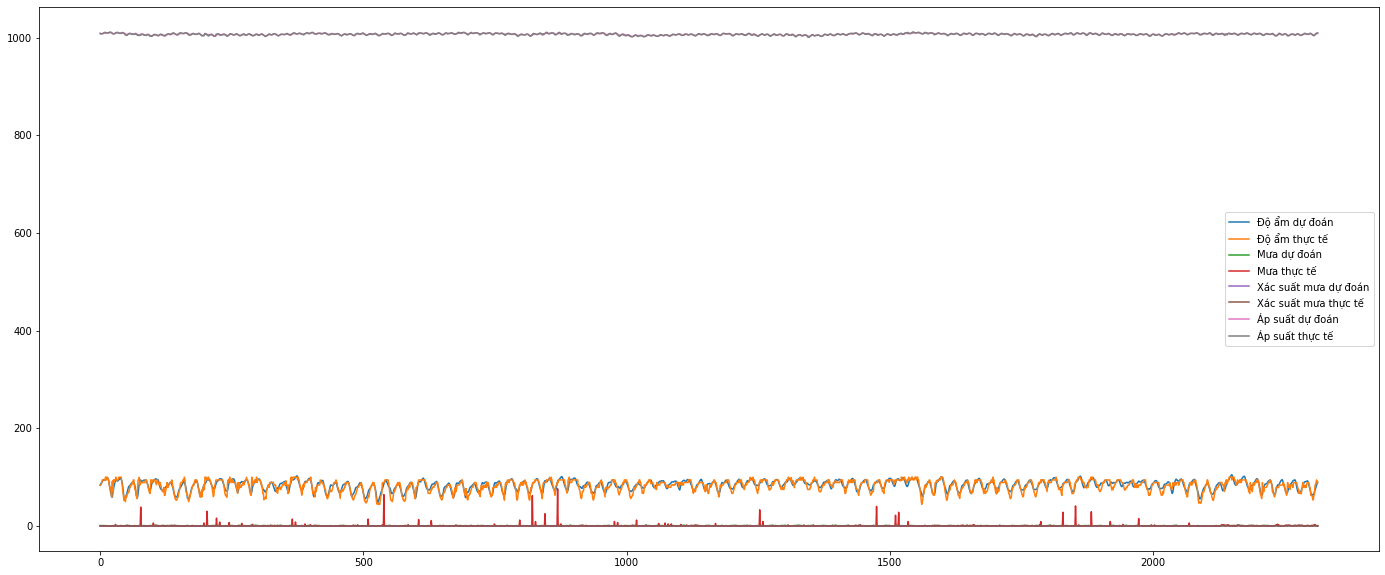

In [ ]:
model = load_model(model_path)
plot_predictions(model, X_test, y_test, df_temp)

##### Visualize

Độ ẩm

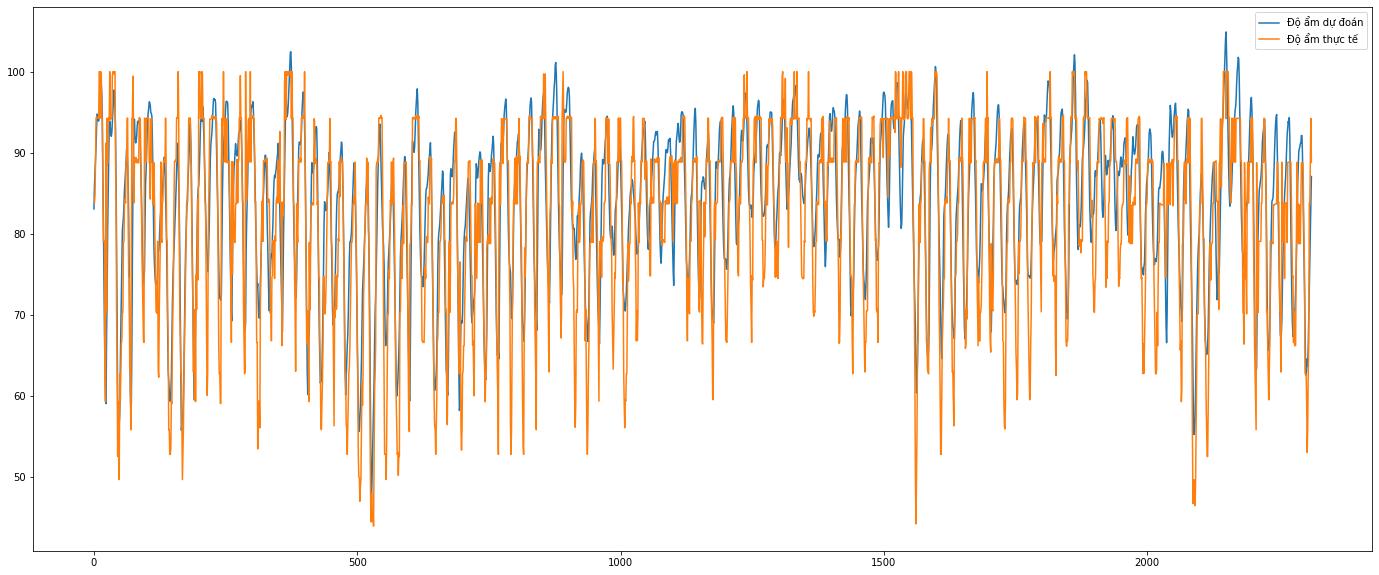

In [ ]:
plot_prediction('Độ ẩm')

Mưa

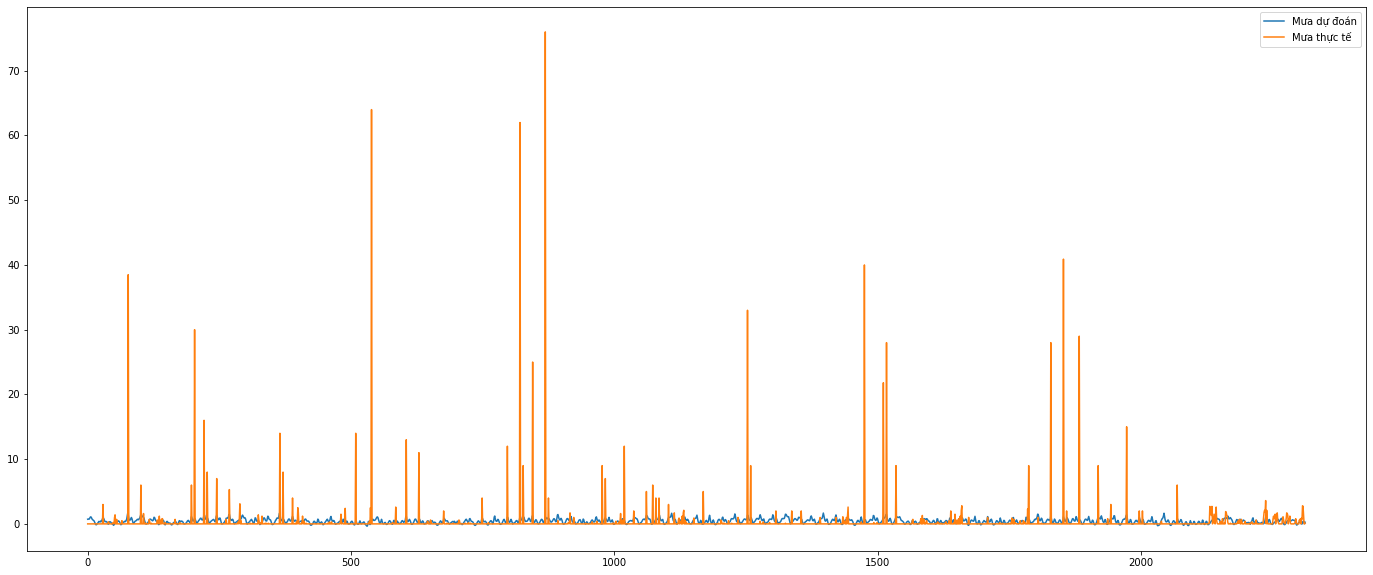

In [ ]:
plot_prediction('Mưa')

Xác suất mưa

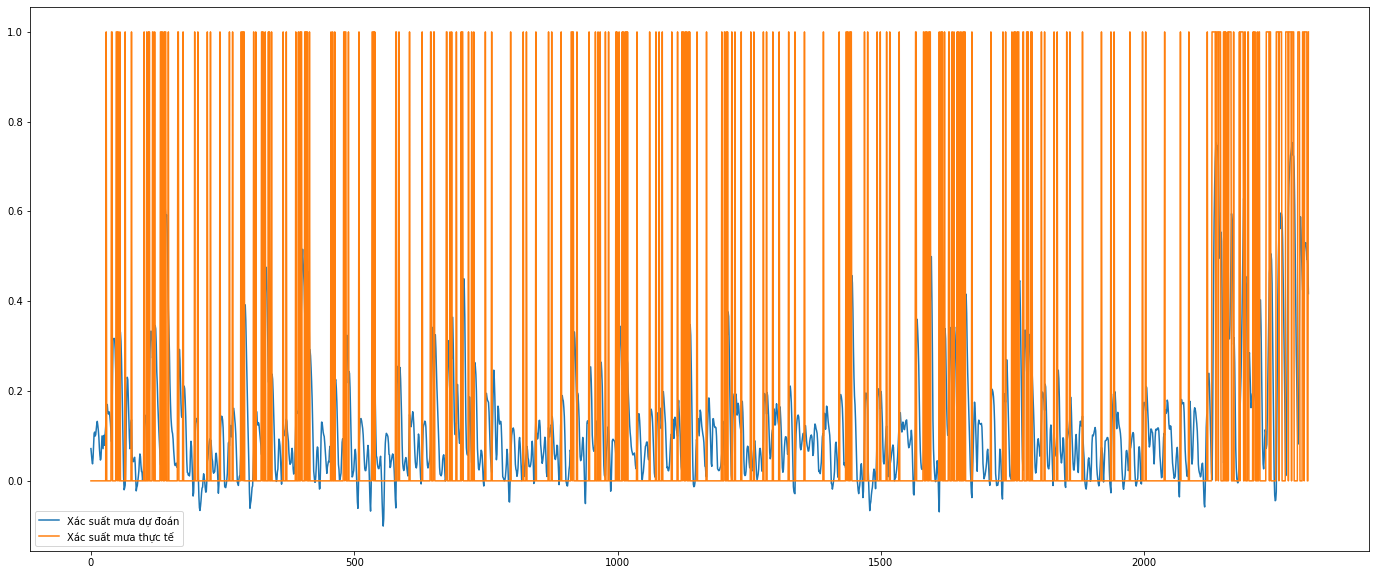

In [ ]:
plot_prediction('Xác suất mưa')

Áp suất

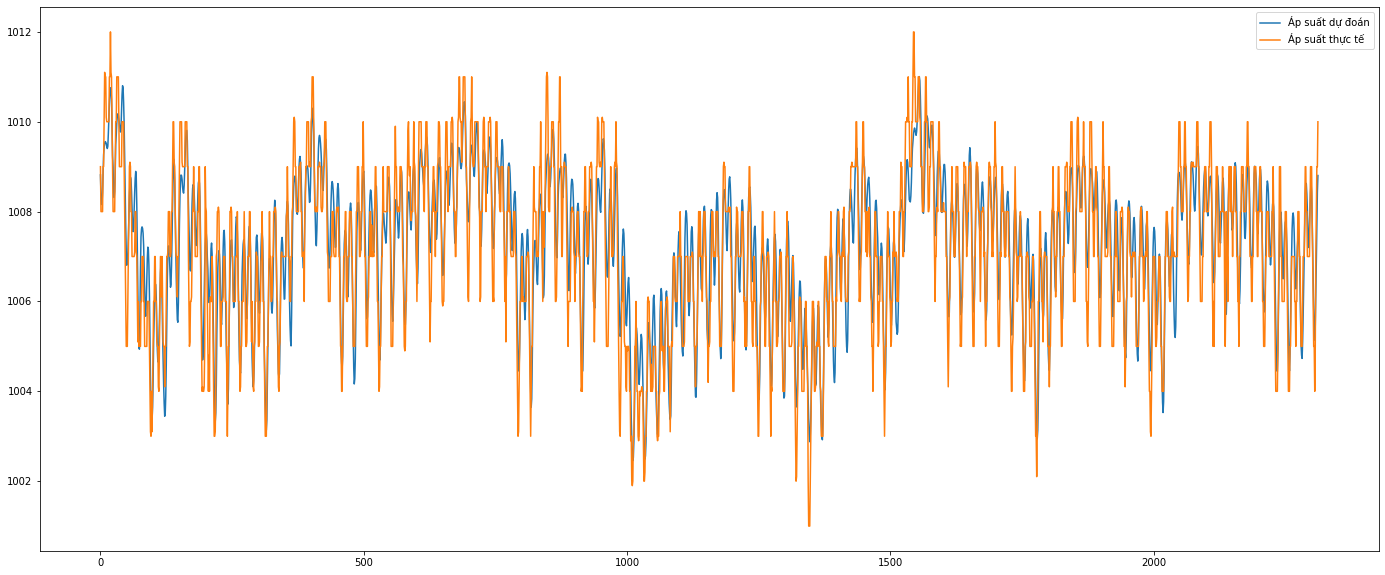

In [ ]:
plot_prediction('Áp suất')

# Tốc độ gió + Hướng gió

### Khai thác dữ liệu cần thiết

In [ ]:
df_temp = df[[
    'Gió X',
    'Gió Y',
    'Ngày sin', 'Ngày cos', 'Năm sin', 'Năm cos']]

### Tách dữ liệu

In [ ]:
X, y = df_to_X_y(df_temp, WINDOW_SIZE)

length = len(X)
begin = int(length * TRAIN_RATIO)
end = int(length * (TRAIN_RATIO + VALRATIO))

X_train, y_train = X[ : begin], y[ : begin]
X_val, y_val = X[begin : end], y[begin : end]
X_test, y_test = X[end : ], y[end : ]

X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_val = np.asarray(X_val).astype('float32')
y_val = np.asarray(y_val).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

### Chuẩn hóa dữ liệu

In [ ]:
mean, std = [], []

for i in range(len(df_temp.columns) - 4):
  mean.append(np.mean(X_train[:, :, i]))
  std.append(np.std(X_train[:, :, i]))

for i in range(len(df_temp.columns) - 4):
  X_train[:, :, i] = (X_train[:, :, i] - mean[i]) / std[i]
  X_val[:, :, i] = (X_val[:, :, i] - mean[i]) / std[i]
  X_test[:, :, i] = (X_test[:, :, i] - mean[i]) / std[i]
   
  y_train[:, i] = (y_train[:, i] - mean[i]) / std[i]
  y_val[:, i] = (y_val[:, i] - mean[i]) / std[i]
  y_test[:, i] = (y_test[:, i] - mean[i]) / std[i]

### Model

##### Train

In [ ]:
model_path = drive_path + 'Model_Gio/'
cp_bs = ModelCheckpoint(model_path, save_best_only=True)

model = Sequential()
model.add(InputLayer((WINDOW_SIZE, len(df_temp.columns))))
model.add(Conv1D(64, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(16, 'relu'))
model.add(Dense(len(df_temp.columns) - 4, 'linear'))

model.summary()

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=LR), metrics=[RootMeanSquaredError()])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, callbacks=[cp_bs, cp_es])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 23, 64)            832       
                                                                 
 flatten_1 (Flatten)         (None, 1472)              0         
                                                                 
 dense_5 (Dense)             (None, 16)                23568     
                                                                 
 dense_6 (Dense)             (None, 2)                 34        
                                                                 
Total params: 24,434
Trainable params: 24,434
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
579/579 [==============================] - 3s 4ms/step - loss: 0.5945 - root_mean_squared_error: 0.7710 - val_loss: 0.5749 - val_root_mean_squared_error: 0.7582
Epoch 2/50

##### Test

Gió X dự đoán  Gió X thực tế  Gió Y dự đoán  Gió Y thực tế
0         -6.053175      -4.618967      -1.339158      -2.797346
1         -6.960305      -8.140638      -1.673404       4.700000
2        -10.583044      -5.975575       1.722512       3.450000
3         -7.536613      -5.600000       2.207440       9.699485
4         -6.361773      -3.214989       4.634438       8.833111
...             ...            ...            ...            ...
2309      -7.985454     -13.068750      -1.180224      -2.469366
2310      -9.550721      -7.200817      -4.324624      -6.042203
2311      -7.936255      -4.471526      -6.236532      -3.027451
2312      -5.951660      -7.882347      -4.526386      -6.314951
2313      -4.740903      -7.199221      -5.490469      -8.579698

[2314 rows x 4 columns]

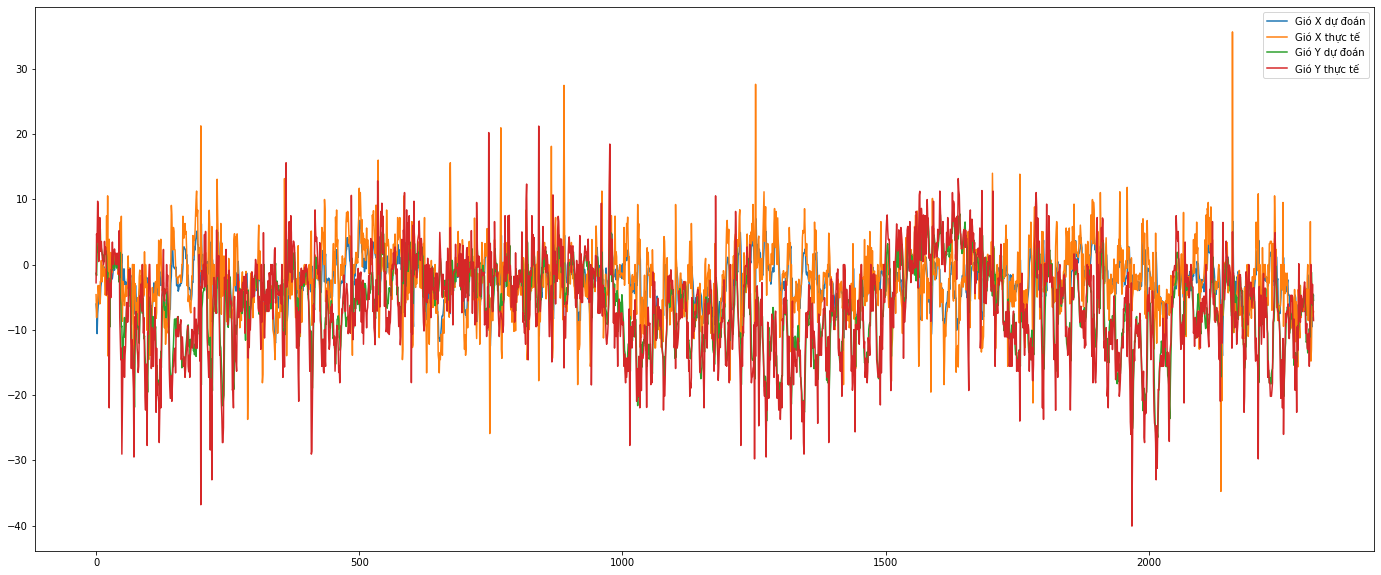

In [ ]:
model = load_model(model_path)
plot_predictions(model, X_test, y_test, df_temp)

##### Visualize

Gió X

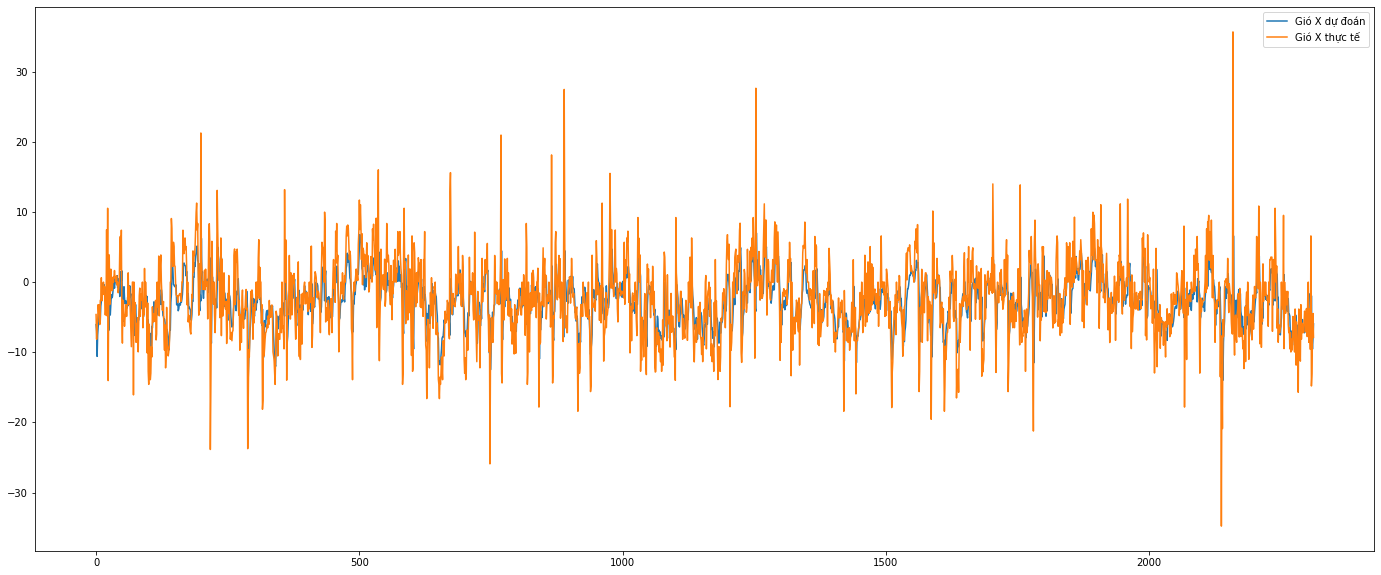

In [ ]:
plot_prediction('Gió X')

Gió Y

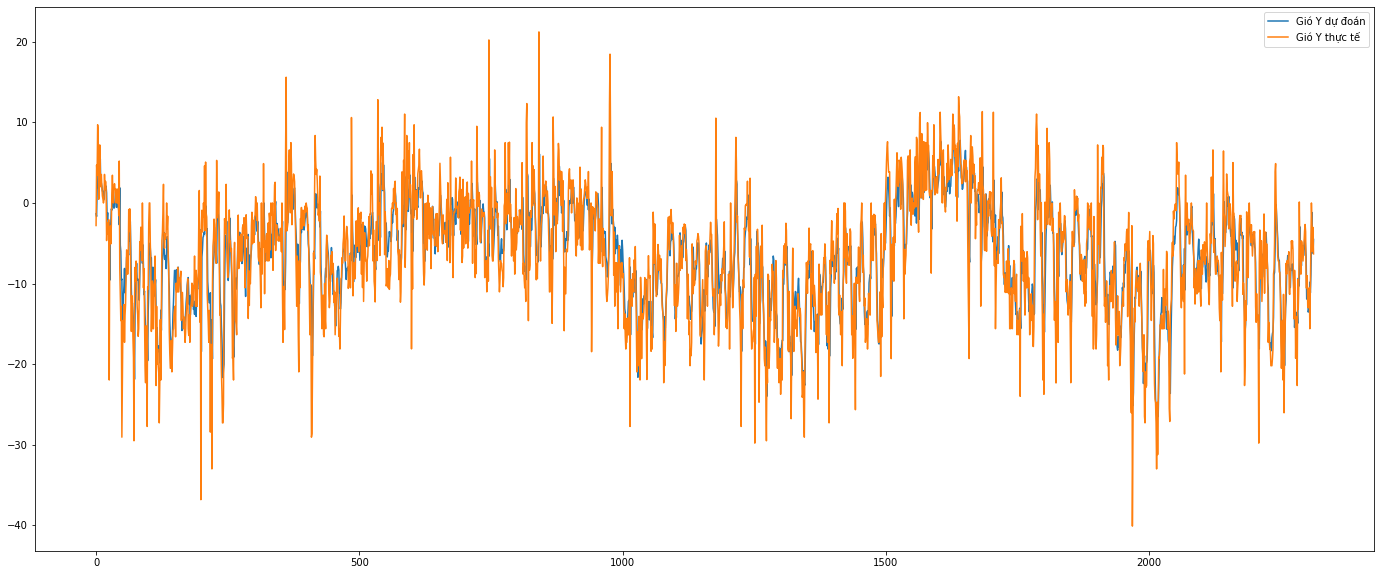

In [ ]:
plot_prediction('Gió Y')

# Sương mù + Mây bao phủ + Tầm nhìn + Chỉ số UV

### Khai thác dữ liệu cần thiết

In [ ]:
df_temp = df[[
    'Sương mù',
    'Mây bao phủ',
    'Tầm nhìn',
    'Chỉ số UV',
    'Ngày sin', 'Ngày cos', 'Năm sin', 'Năm cos']]

### Tách dữ liệu

In [ ]:
X, y = df_to_X_y(df_temp, WINDOW_SIZE)

length = len(X)
begin = int(length * TRAIN_RATIO)
end = int(length * (TRAIN_RATIO + VALRATIO))

X_train, y_train = X[ : begin], y[ : begin]
X_val, y_val = X[begin : end], y[begin : end]
X_test, y_test = X[end : ], y[end : ]

X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_val = np.asarray(X_val).astype('float32')
y_val = np.asarray(y_val).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

### Chuẩn hóa dữ liệu

In [ ]:
mean, std = [], []

for i in range(len(df_temp.columns) - 4):
  mean.append(np.mean(X_train[:, :, i]))
  std.append(np.std(X_train[:, :, i]))

for i in range(len(df_temp.columns) - 4):
  X_train[:, :, i] = (X_train[:, :, i] - mean[i]) / std[i]
  X_val[:, :, i] = (X_val[:, :, i] - mean[i]) / std[i]
  X_test[:, :, i] = (X_test[:, :, i] - mean[i]) / std[i]
   
  y_train[:, i] = (y_train[:, i] - mean[i]) / std[i]
  y_val[:, i] = (y_val[:, i] - mean[i]) / std[i]
  y_test[:, i] = (y_test[:, i] - mean[i]) / std[i]

### Model

##### Train

In [ ]:
model_path = drive_path + 'Model_SuongMu_UV/'
cp_bs = ModelCheckpoint(model_path, save_best_only=True)

model = Sequential()
model.add(InputLayer((WINDOW_SIZE, len(df_temp.columns))))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32,))
model.add(Dense(32, 'relu'))
model.add(Dense(16, 'relu'))
model.add(Dense(len(df_temp.columns) - 4, 'linear'))

model.summary()

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=LR), metrics=[RootMeanSquaredError()])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, callbacks=[cp_bs, cp_es])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 64)            18688     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 4)                 68        
                                                                 
Total params: 32,756
Trainable params: 32,756
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
578/579 [============================>.

579/579 [==============================] - 29s 44ms/step - loss: 0.8907 - root_mean_squared_error: 0.9438 - val_loss: 0.7281 - val_root_mean_squared_error: 0.8533
Epoch 2/50
578/579 [============================>.] - ETA: 0s - loss: 0.7296 - root_mean_squared_error: 0.8542

579/579 [==============================] - 23s 41ms/step - loss: 0.7296 - root_mean_squared_error: 0.8542 - val_loss: 0.6504 - val_root_mean_squared_error: 0.8065
Epoch 3/50
577/579 [============================>.] - ETA: 0s - loss: 0.6343 - root_mean_squared_error: 0.7964

579/579 [==============================] - 24s 41ms/step - loss: 0.6342 - root_mean_squared_error: 0.7963 - val_loss: 0.5838 - val_root_mean_squared_error: 0.7641
Epoch 4/50
577/579 [============================>.] - ETA: 0s - loss: 0.5593 - root_mean_squared_error: 0.7478

579/579 [==============================] - 24s 41ms/step - loss: 0.5595 - root_mean_squared_error: 0.7480 - val_loss: 0.5399 - val_root_mean_squared_error: 0.7348
Epoch 5/50
578/579 [============================>.] - ETA: 0s - loss: 0.5052 - root_mean_squared_error: 0.7108

579/579 [==============================] - 24s 41ms/step - loss: 0.5051 - root_mean_squared_error: 0.7107 - val_loss: 0.5215 - val_root_mean_squared_error: 0.7221
Epoch 6/50
578/579 [============================>.] - ETA: 0s - loss: 0.4712 - root_mean_squared_error: 0.6864

579/579 [==============================] - 24s 41ms/step - loss: 0.4712 - root_mean_squared_error: 0.6865 - val_loss: 0.5132 - val_root_mean_squared_error: 0.7163
Epoch 7/50
579/579 [==============================] - ETA: 0s - loss: 0.4491 - root_mean_squared_error: 0.6701

579/579 [==============================] - 26s 44ms/step - loss: 0.4491 - root_mean_squared_error: 0.6701 - val_loss: 0.5025 - val_root_mean_squared_error: 0.7089
Epoch 8/50
578/579 [============================>.] - ETA: 0s - loss: 0.4325 - root_mean_squared_error: 0.6576

579/579 [==============================] - 24s 41ms/step - loss: 0.4324 - root_mean_squared_error: 0.6576 - val_loss: 0.4983 - val_root_mean_squared_error: 0.7059
Epoch 9/50
578/579 [============================>.] - ETA: 0s - loss: 0.4185 - root_mean_squared_error: 0.6469

579/579 [==============================] - 24s 42ms/step - loss: 0.4185 - root_mean_squared_error: 0.6469 - val_loss: 0.4901 - val_root_mean_squared_error: 0.7001
Epoch 10/50
577/579 [============================>.] - ETA: 0s - loss: 0.4062 - root_mean_squared_error: 0.6373

579/579 [==============================] - 23s 40ms/step - loss: 0.4060 - root_mean_squared_error: 0.6371 - val_loss: 0.4843 - val_root_mean_squared_error: 0.6959
Epoch 11/50
577/579 [============================>.] - ETA: 0s - loss: 0.3946 - root_mean_squared_error: 0.6282

579/579 [==============================] - 24s 42ms/step - loss: 0.3949 - root_mean_squared_error: 0.6284 - val_loss: 0.4739 - val_root_mean_squared_error: 0.6884
Epoch 12/50
579/579 [==============================] - ETA: 0s - loss: 0.3850 - root_mean_squared_error: 0.6205

579/579 [==============================] - 23s 40ms/step - loss: 0.3850 - root_mean_squared_error: 0.6205 - val_loss: 0.4680 - val_root_mean_squared_error: 0.6841
Epoch 13/50
578/579 [============================>.] - ETA: 0s - loss: 0.3759 - root_mean_squared_error: 0.6131

579/579 [==============================] - 26s 45ms/step - loss: 0.3759 - root_mean_squared_error: 0.6131 - val_loss: 0.4638 - val_root_mean_squared_error: 0.6811
Epoch 14/50
577/579 [============================>.] - ETA: 0s - loss: 0.3674 - root_mean_squared_error: 0.6061

579/579 [==============================] - 24s 41ms/step - loss: 0.3674 - root_mean_squared_error: 0.6062 - val_loss: 0.4541 - val_root_mean_squared_error: 0.6739
Epoch 15/50
578/579 [============================>.] - ETA: 0s - loss: 0.3594 - root_mean_squared_error: 0.5995

579/579 [==============================] - 24s 42ms/step - loss: 0.3594 - root_mean_squared_error: 0.5995 - val_loss: 0.4446 - val_root_mean_squared_error: 0.6668
Epoch 16/50
577/579 [============================>.] - ETA: 0s - loss: 0.3517 - root_mean_squared_error: 0.5931

579/579 [==============================] - 24s 41ms/step - loss: 0.3517 - root_mean_squared_error: 0.5931 - val_loss: 0.4406 - val_root_mean_squared_error: 0.6638
Epoch 17/50
578/579 [============================>.] - ETA: 0s - loss: 0.3446 - root_mean_squared_error: 0.5870

579/579 [==============================] - 24s 41ms/step - loss: 0.3446 - root_mean_squared_error: 0.5870 - val_loss: 0.4296 - val_root_mean_squared_error: 0.6555
Epoch 18/50
579/579 [==============================] - ETA: 0s - loss: 0.3379 - root_mean_squared_error: 0.5813

579/579 [==============================] - 25s 44ms/step - loss: 0.3379 - root_mean_squared_error: 0.5813 - val_loss: 0.4255 - val_root_mean_squared_error: 0.6523
Epoch 19/50
577/579 [============================>.] - ETA: 0s - loss: 0.3320 - root_mean_squared_error: 0.5762

579/579 [==============================] - 24s 41ms/step - loss: 0.3317 - root_mean_squared_error: 0.5760 - val_loss: 0.4188 - val_root_mean_squared_error: 0.6472
Epoch 20/50
579/579 [==============================] - ETA: 0s - loss: 0.3257 - root_mean_squared_error: 0.5707

579/579 [==============================] - 24s 42ms/step - loss: 0.3257 - root_mean_squared_error: 0.5707 - val_loss: 0.4133 - val_root_mean_squared_error: 0.6429
Epoch 21/50
578/579 [============================>.] - ETA: 0s - loss: 0.3205 - root_mean_squared_error: 0.5661

579/579 [==============================] - 24s 41ms/step - loss: 0.3205 - root_mean_squared_error: 0.5661 - val_loss: 0.4067 - val_root_mean_squared_error: 0.6377
Epoch 22/50
578/579 [============================>.] - ETA: 0s - loss: 0.3155 - root_mean_squared_error: 0.5617

579/579 [==============================] - 24s 42ms/step - loss: 0.3155 - root_mean_squared_error: 0.5617 - val_loss: 0.4028 - val_root_mean_squared_error: 0.6346
Epoch 23/50
578/579 [============================>.] - ETA: 0s - loss: 0.3111 - root_mean_squared_error: 0.5578

579/579 [==============================] - 23s 41ms/step - loss: 0.3111 - root_mean_squared_error: 0.5578 - val_loss: 0.3998 - val_root_mean_squared_error: 0.6323
Epoch 24/50
578/579 [============================>.] - ETA: 0s - loss: 0.3069 - root_mean_squared_error: 0.5540

579/579 [==============================] - 25s 44ms/step - loss: 0.3068 - root_mean_squared_error: 0.5539 - val_loss: 0.3938 - val_root_mean_squared_error: 0.6275
Epoch 25/50
578/579 [============================>.] - ETA: 0s - loss: 0.3029 - root_mean_squared_error: 0.5503

579/579 [==============================] - 24s 42ms/step - loss: 0.3028 - root_mean_squared_error: 0.5503 - val_loss: 0.3900 - val_root_mean_squared_error: 0.6245
Epoch 26/50
579/579 [==============================] - ETA: 0s - loss: 0.2992 - root_mean_squared_error: 0.5469

579/579 [==============================] - 24s 42ms/step - loss: 0.2992 - root_mean_squared_error: 0.5469 - val_loss: 0.3875 - val_root_mean_squared_error: 0.6225
Epoch 27/50
578/579 [============================>.] - ETA: 0s - loss: 0.2958 - root_mean_squared_error: 0.5439

579/579 [==============================] - 24s 42ms/step - loss: 0.2957 - root_mean_squared_error: 0.5438 - val_loss: 0.3828 - val_root_mean_squared_error: 0.6187
Epoch 28/50
578/579 [============================>.] - ETA: 0s - loss: 0.2923 - root_mean_squared_error: 0.5406

579/579 [==============================] - 24s 42ms/step - loss: 0.2923 - root_mean_squared_error: 0.5406 - val_loss: 0.3808 - val_root_mean_squared_error: 0.6171
Epoch 29/50
577/579 [============================>.] - ETA: 0s - loss: 0.2895 - root_mean_squared_error: 0.5381

579/579 [==============================] - 24s 41ms/step - loss: 0.2893 - root_mean_squared_error: 0.5379 - val_loss: 0.3750 - val_root_mean_squared_error: 0.6124
Epoch 30/50
578/579 [============================>.] - ETA: 0s - loss: 0.2861 - root_mean_squared_error: 0.5349

579/579 [==============================] - 25s 44ms/step - loss: 0.2863 - root_mean_squared_error: 0.5351 - val_loss: 0.3732 - val_root_mean_squared_error: 0.6109
Epoch 31/50
578/579 [============================>.] - ETA: 0s - loss: 0.2839 - root_mean_squared_error: 0.5328

579/579 [==============================] - 24s 42ms/step - loss: 0.2838 - root_mean_squared_error: 0.5328 - val_loss: 0.3679 - val_root_mean_squared_error: 0.6065
Epoch 32/50
578/579 [============================>.] - ETA: 0s - loss: 0.2814 - root_mean_squared_error: 0.5305

579/579 [==============================] - 23s 41ms/step - loss: 0.2814 - root_mean_squared_error: 0.5305 - val_loss: 0.3654 - val_root_mean_squared_error: 0.6045
Epoch 33/50
579/579 [==============================] - ETA: 0s - loss: 0.2791 - root_mean_squared_error: 0.5283

579/579 [==============================] - 24s 42ms/step - loss: 0.2791 - root_mean_squared_error: 0.5283 - val_loss: 0.3628 - val_root_mean_squared_error: 0.6023
Epoch 34/50
577/579 [============================>.] - ETA: 0s - loss: 0.2773 - root_mean_squared_error: 0.5266

579/579 [==============================] - 24s 42ms/step - loss: 0.2773 - root_mean_squared_error: 0.5266 - val_loss: 0.3601 - val_root_mean_squared_error: 0.6001
Epoch 35/50
577/579 [============================>.] - ETA: 0s - loss: 0.2739 - root_mean_squared_error: 0.5233

579/579 [==============================] - 24s 41ms/step - loss: 0.2753 - root_mean_squared_error: 0.5247 - val_loss: 0.3597 - val_root_mean_squared_error: 0.5997
Epoch 36/50
577/579 [============================>.] - ETA: 0s - loss: 0.2734 - root_mean_squared_error: 0.5229

579/579 [==============================] - 25s 44ms/step - loss: 0.2733 - root_mean_squared_error: 0.5228 - val_loss: 0.3550 - val_root_mean_squared_error: 0.5958
Epoch 37/50
579/579 [==============================] - 16s 27ms/step - loss: 0.2717 - root_mean_squared_error: 0.5213 - val_loss: 0.3563 - val_root_mean_squared_error: 0.5969
Epoch 38/50
577/579 [============================>.] - ETA: 0s - loss: 0.2703 - root_mean_squared_error: 0.5199

579/579 [==============================] - 24s 42ms/step - loss: 0.2702 - root_mean_squared_error: 0.5198 - val_loss: 0.3530 - val_root_mean_squared_error: 0.5941
Epoch 39/50
578/579 [============================>.] - ETA: 0s - loss: 0.2689 - root_mean_squared_error: 0.5186

579/579 [==============================] - 24s 42ms/step - loss: 0.2689 - root_mean_squared_error: 0.5186 - val_loss: 0.3482 - val_root_mean_squared_error: 0.5901
Epoch 40/50
579/579 [==============================] - 15s 27ms/step - loss: 0.2676 - root_mean_squared_error: 0.5173 - val_loss: 0.3491 - val_root_mean_squared_error: 0.5908
Epoch 41/50
578/579 [============================>.] - ETA: 0s - loss: 0.2663 - root_mean_squared_error: 0.5160

579/579 [==============================] - 24s 42ms/step - loss: 0.2663 - root_mean_squared_error: 0.5160 - val_loss: 0.3465 - val_root_mean_squared_error: 0.5887
Epoch 42/50
579/579 [==============================] - ETA: 0s - loss: 0.2651 - root_mean_squared_error: 0.5149

579/579 [==============================] - 25s 44ms/step - loss: 0.2651 - root_mean_squared_error: 0.5149 - val_loss: 0.3450 - val_root_mean_squared_error: 0.5873
Epoch 43/50
577/579 [============================>.] - ETA: 0s - loss: 0.2644 - root_mean_squared_error: 0.5142

579/579 [==============================] - 24s 42ms/step - loss: 0.2641 - root_mean_squared_error: 0.5139 - val_loss: 0.3434 - val_root_mean_squared_error: 0.5860
Epoch 44/50
579/579 [==============================] - 15s 27ms/step - loss: 0.2632 - root_mean_squared_error: 0.5130 - val_loss: 0.3438 - val_root_mean_squared_error: 0.5864
Epoch 45/50
577/579 [============================>.] - ETA: 0s - loss: 0.2623 - root_mean_squared_error: 0.5121

579/579 [==============================] - 24s 42ms/step - loss: 0.2622 - root_mean_squared_error: 0.5120 - val_loss: 0.3402 - val_root_mean_squared_error: 0.5833
Epoch 46/50
578/579 [============================>.] - ETA: 0s - loss: 0.2615 - root_mean_squared_error: 0.5114

579/579 [==============================] - 24s 42ms/step - loss: 0.2614 - root_mean_squared_error: 0.5113 - val_loss: 0.3398 - val_root_mean_squared_error: 0.5830
Epoch 47/50
579/579 [==============================] - 15s 27ms/step - loss: 0.2606 - root_mean_squared_error: 0.5104 - val_loss: 0.3402 - val_root_mean_squared_error: 0.5833
Epoch 48/50
578/579 [============================>.] - ETA: 0s - loss: 0.2597 - root_mean_squared_error: 0.5096

579/579 [==============================] - 25s 43ms/step - loss: 0.2597 - root_mean_squared_error: 0.5096 - val_loss: 0.3388 - val_root_mean_squared_error: 0.5821
Epoch 49/50
577/579 [============================>.] - ETA: 0s - loss: 0.2590 - root_mean_squared_error: 0.5090

579/579 [==============================] - 26s 45ms/step - loss: 0.2590 - root_mean_squared_error: 0.5089 - val_loss: 0.3368 - val_root_mean_squared_error: 0.5803
Epoch 50/50
578/579 [============================>.] - ETA: 0s - loss: 0.2584 - root_mean_squared_error: 0.5083

579/579 [==============================] - 24s 42ms/step - loss: 0.2583 - root_mean_squared_error: 0.5083 - val_loss: 0.3365 - val_root_mean_squared_error: 0.5801


##### Test

Sương mù dự đoán  Sương mù thực tế  Mây bao phủ dự đoán  \
0            24.247749              25.0            83.098145   
1            24.589899              25.0            57.756416   
2            25.149035              25.1            75.849335   
3            24.960773              26.0            74.936989   
4            25.169481              26.0            78.643974   
...                ...               ...                  ...   
2309         24.781034              24.0            59.768425   
2310         24.818775              24.0            75.322647   
2311         24.546377              25.0            77.204750   
2312         24.683372              25.0            81.851707   
2313         24.769196              25.0            83.300873   

      Mây bao phủ thực tế  Tầm nhìn dự đoán  Tầm nhìn thực tế  \
0               50.000000          9.072806              10.0   
1               88.800003          9.333609              10.0   
2               88.900002          9.461626              10.0   
3               88.800003          9.659110              10.0   
4               88.800003          9.603193              10.0   
...                   ...               ...               ...   
2309            88.000000          8.033838               8.0   
2310            88.000000          8.564361              10.0   
2311            88.000000          9.549948              10.0   
2312            88.000000          9.777757              10.0   
2313            88.000000          9.884778              10.0   

      Chỉ số UV dự đoán  Chỉ số UV thực tế  
0              7.274843           4.000000  
1              3.682384           3.000000  
2              2.061593           3.000000  
3              2.229940           2.000000  
4              2.721362           3.395826  
...                 ...                ...  
2309           2.587312           3.581509  
2310           2.796632           3.581664  
2311           2.882785           3.581819  
2312           2.933164           3.581973  
2313           2.910586           3.582128  

[2314 rows x 8 columns]

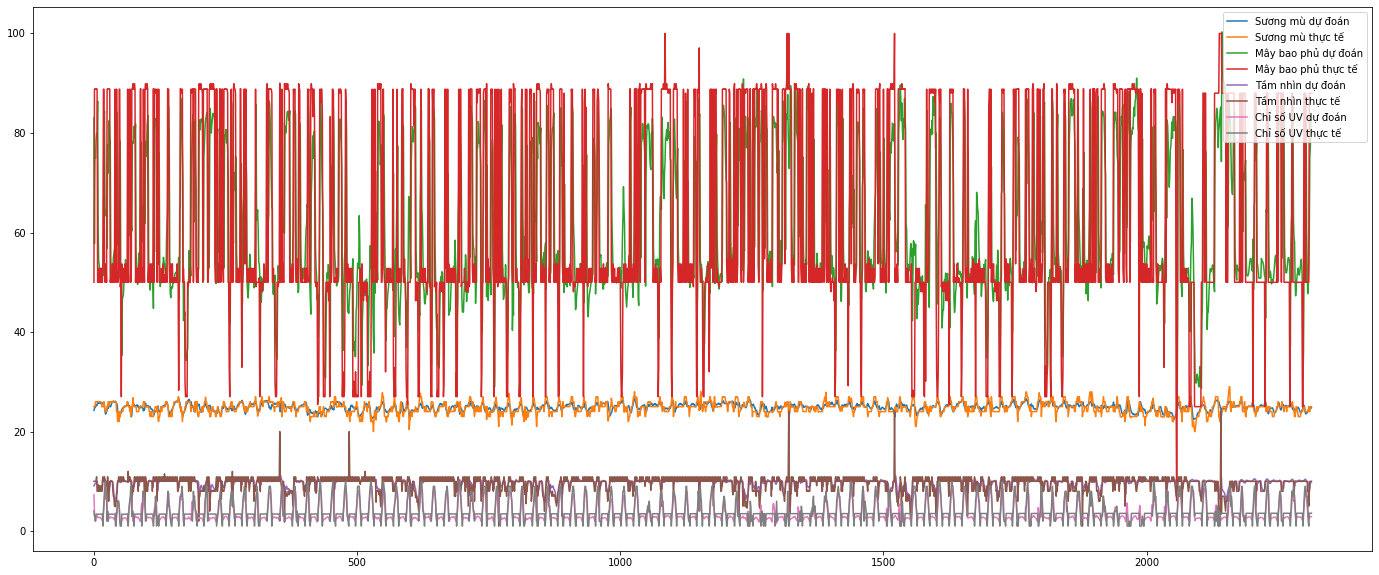

In [ ]:
model = load_model(model_path)
plot_predictions(model, X_test, y_test, df_temp)

##### Visualize

Sương mù

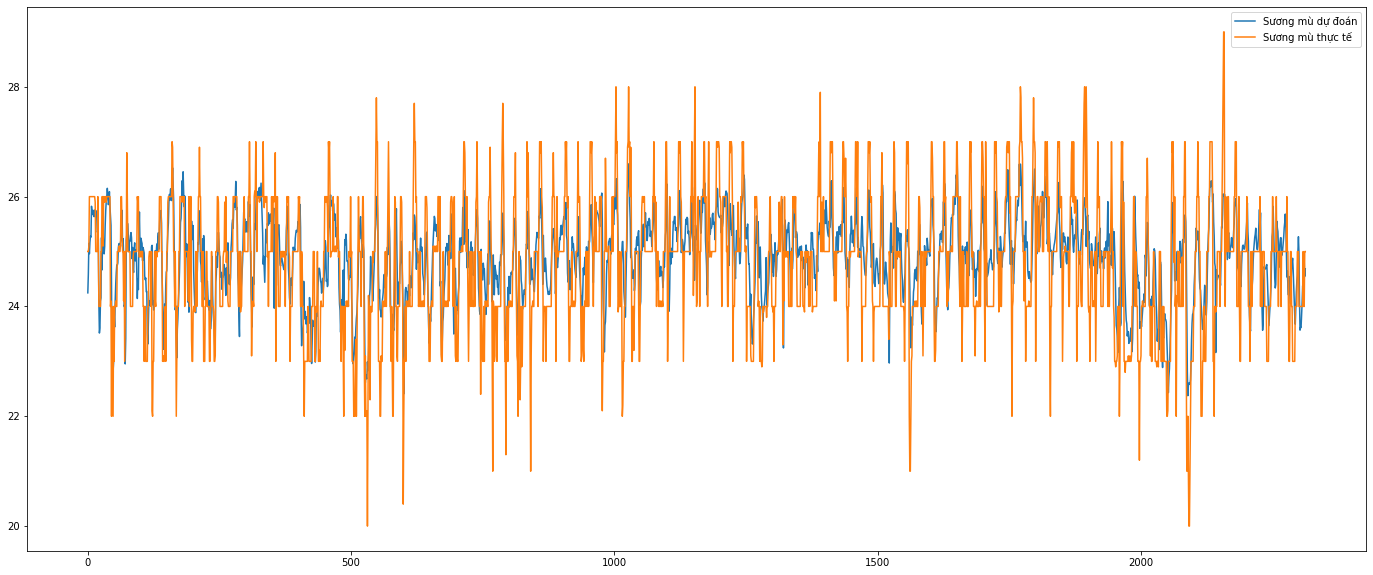

In [ ]:
plot_prediction('Sương mù')

Mây bao phủ

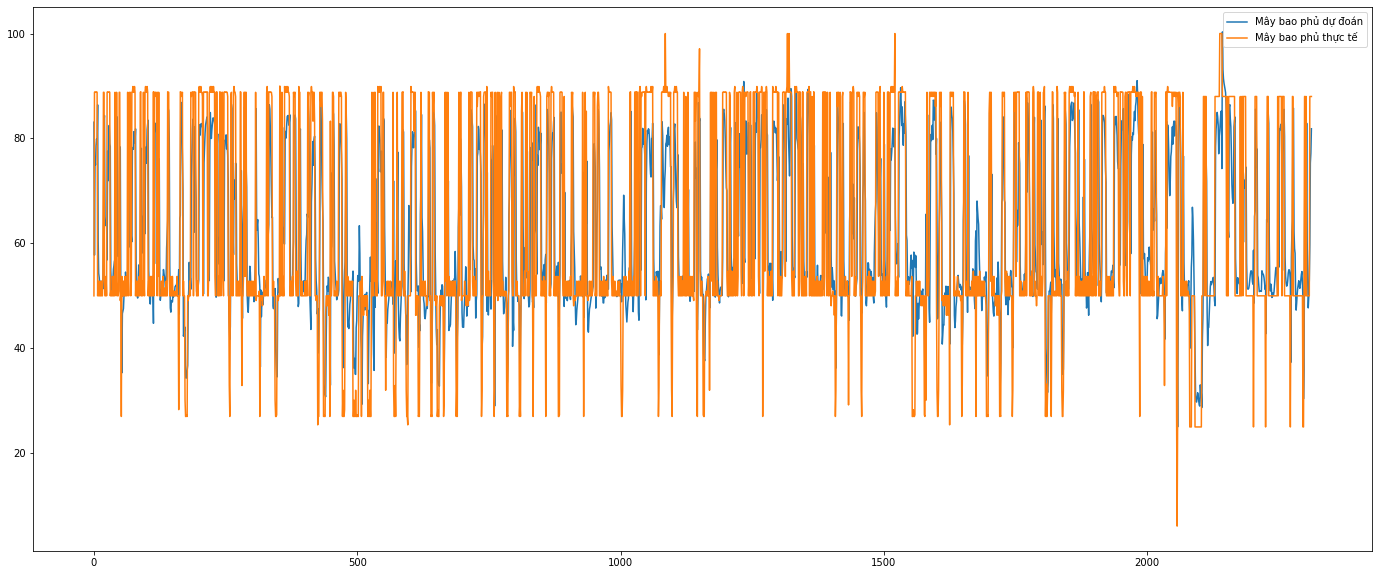

In [ ]:
plot_prediction('Mây bao phủ')

Tầm nhìn

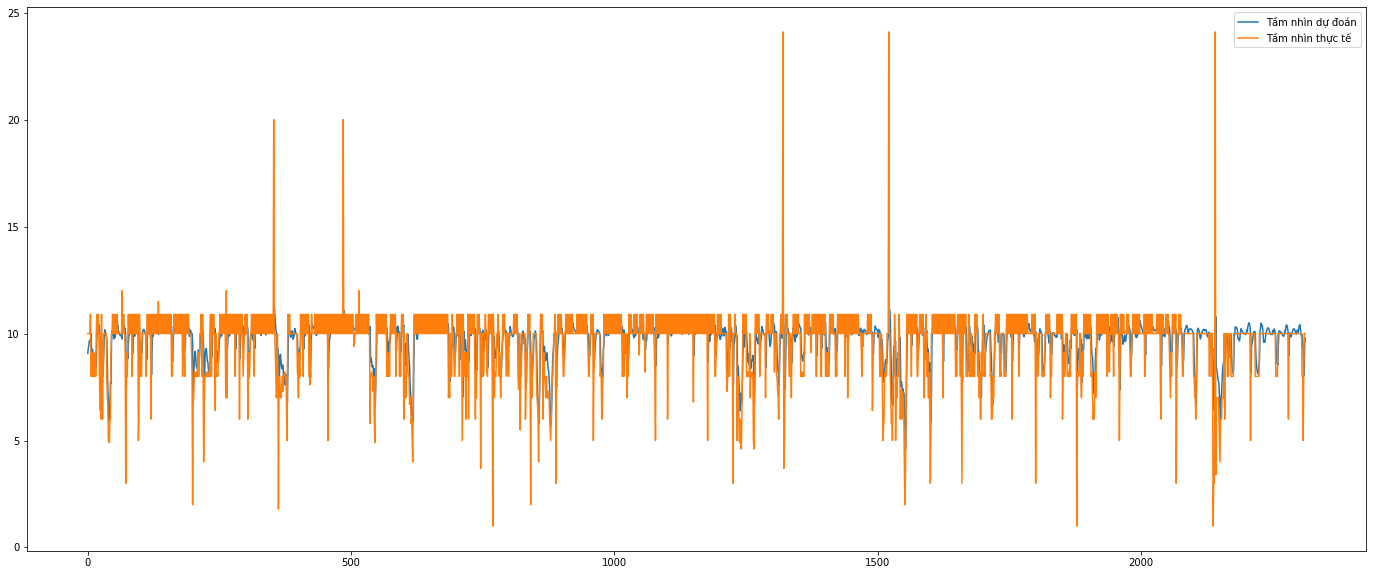

In [ ]:
plot_prediction('Tầm nhìn')

Chỉ số UV

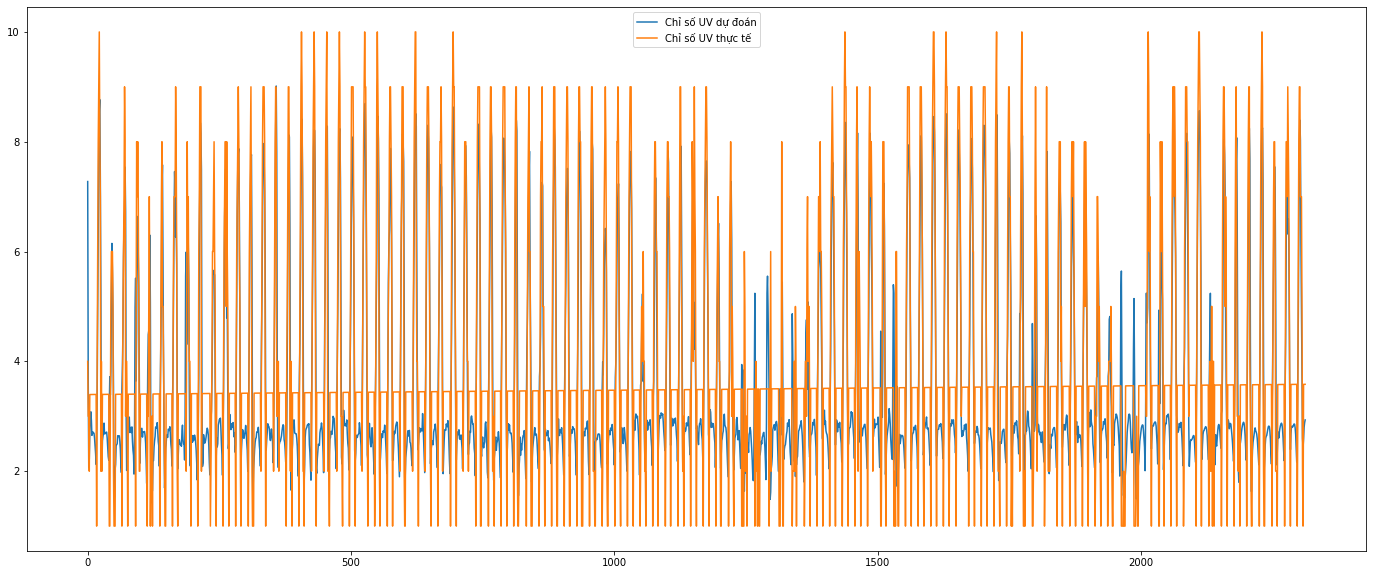

In [ ]:
plot_prediction('Chỉ số UV')